
# **Importing Necessary libraries** #
---



In [1]:
import torch
import os
import pickle
import torch.nn.functional as F
import numpy as np

from torch import nn,optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

print("Pytorch Version:",torch.__version__)
print("GPU Avaiable:",torch.cuda.is_available())

device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
print("Setting device to:",device)

Pytorch Version: 1.8.1+cu101
GPU Avaiable: True
Setting device to: cuda


# **Importing dataset** #

In [11]:
with open("/content/drive/MyDrive/MinorProject/Dataset/numbers_dataset.pickle","rb") as file:
  dataset = pickle.load(file)

In [12]:
with open("/content/drive/MyDrive/MinorProjectDataset/label_digits.pickle","rb") as file:
  label = pickle.load(file)


In [15]:
dataset.shape,label.shape,dataset.min(),dataset.max(),label.min(),label.max()

((100000, 1, 64, 64), (100000,), 0, 255, 0, 9)

In [18]:
class Nepali_Dataset(Dataset):
  def __init__(self, image, label):
    self.image = image
    self.label = label
    self.n_samples = image.shape[0]

  def __getitem__(self, index):
    return self.image[index], self.label[index]

  def __len__(self):
    return self.n_samples


In [64]:
def visualize_dataset(images_list, size = 6, shape = (5, 4)):
  fig = plt.figure(figsize = (size, size))
  grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.04)
  for ax, image in zip(grid, images_list):
    ax.axis('off')
    ax.imshow(image[0],cmap='gray')
    

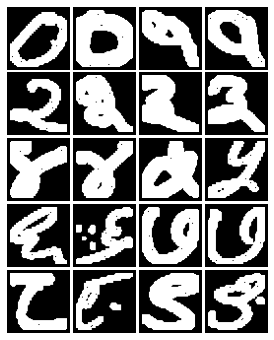

In [65]:
visualize_dataset(dataset[0:100000:5000])

In [19]:
class_num = len(set(label))
print("number of classes:", class_num)

number of classes: 10


#**Classifier**#

In [21]:
class Digits_Classifier(nn.Module):
  def __init__(self, **kwargs):
    super(Digits_Classifier, self).__init__()

    self.maps = kwargs['maps']
    self.lr = kwargs['lr']
    self.epochs = kwargs['epochs']
    self.class_num = kwargs['class_num']

    self.conv_layers = nn.Sequential(
        #nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1)
        nn.Conv2d(1, self.maps, 4, 2, 1),
        nn.LeakyReLU(0.2), # shape -> maps, 32, 32
        
        nn.Conv2d(self.maps, 2 * self.maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(2 * self.maps),
        nn.LeakyReLU(0.2), # shape -> 2 * maps, 16, 16
        
        nn.Conv2d(2 * self.maps, 4 * self.maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(4 * self.maps),
        nn.LeakyReLU(0.2), # shape -> 4 * maps, 8, 8
        
        nn.Conv2d(4 * self.maps, 8 * self.maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(8 * self.maps),
        nn.LeakyReLU(0.2), # shape -> 8 * maps, 4, 4
        
        nn.Conv2d(8 * self.maps, 16 * self.maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(16 * self.maps),
        nn.LeakyReLU(0.2), # shape -> 16 * maps, 2, 2
    )

    self.dense_layers = nn.Sequential(
      nn.Flatten(), 
      nn.Linear(256 * 2 * 2, 512),
      nn.ReLU(0.2),
      nn.Linear(512, 256),
      nn.ReLU(0.2),
      nn.Linear(256, 128),
      nn.ReLU(0.2),
      nn.Linear(128, 64),
      nn.ReLU(0.2),
      nn.Linear(64, self.class_num)
    )

    #create optimizer, using stochastic gradient descent
    self.optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)

    #counter and accumulator for progress
    self.counter = 0
    self.train_losses = []
    self.test_losses = []

    self.split_dataset()

  def split_dataset(self):
    Data = Nepali_Dataset(dataset, label)
    # Dividing Dataset into training and test set
    train_set, test_set = random_split(Data, [99000, 1000])

    self.train_loader = DataLoader(train_set, batch_size = 64, shuffle = True, drop_last = True)
    self.test_loader = DataLoader(test_set, batch_size = 64, shuffle = True, drop_last = True)

  def forward(self, x):
    x = self.conv_layers(x)
    out = self.dense_layers(x)
    return out
  
  def loss_function(self, outputs, targets):
    return F.cross_entropy(outputs, targets)

  def train(self):
          
    for i in range(self.epochs):
      
      for images, targets in tqdm(self.train_loader,desc = f'Epoch({i + 1}/{self.epochs}'):
        
        images, targets = images.float().to(device), targets.to(device)
        
        #calculate the output of the network 
        outputs = self.forward(images)
        
        #calculate the loss 
        loss = self.loss_function(outputs, targets)

        #increase the counter of training and accumulate the error in every 10 count
        self.counter += 1
        if (self.counter % 10 == 0):
          self.train_losses.append(loss.item())
          
        # zero gradients, perform a backward pass, update weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
  def test(self):
   
    for images, targets in tqdm(self.test_loader,desc = f'Epoch({self.counter + 1}'):

      images, targets = images.float().to(device), targets.to(device)

      outputs = self.forward(images)

      loss = self.loss_function(outputs, targets)

      self.test_losses.append(loss.item())

  def accuracy(self):
    n_correct = 0.
    n_total = 0.
    for images, targets in tqdm(self.test_loader, desc = f'Epoch:{n_total+1}'):
      # move data to GPU
      images, targets = images.float().to(device), targets.to(device)

      # Forward pass
      outputs = self.forward(images)

      # Get prediction
      # torch.max returns both max and argmax
      _, predictions = torch.max(outputs, 1)
      
      # update counts
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]

    test_acc = n_correct / n_total
    print(f"Test acc: {test_acc:.4f}")

    # Finally, we can add a function plot_progress() to show losses accumulated during training
  def plot_losses(self, loss):

    plt.figure(figsize=(16,8))
    plt.plot(loss, label="Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title('Loss Vs Iterations');
    plt.show()

# **Training and Analyzing**

In [22]:
model = Digits_Classifier(maps=16, lr=0.01, epochs=10,class_num=class_num).to(device)
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             272
         LeakyReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           8,192
       BatchNorm2d-4           [-1, 32, 16, 16]              64
         LeakyReLU-5           [-1, 32, 16, 16]               0
            Conv2d-6             [-1, 64, 8, 8]          32,768
       BatchNorm2d-7             [-1, 64, 8, 8]             128
         LeakyReLU-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 4, 4]         131,072
      BatchNorm2d-10            [-1, 128, 4, 4]             256
        LeakyReLU-11            [-1, 128, 4, 4]               0
           Conv2d-12            [-1, 256, 2, 2]         524,288
      BatchNorm2d-13            [-1, 256, 2, 2]             512
        LeakyReLU-14            [-1, 25

In [23]:
model.train()

In [28]:
model.test()

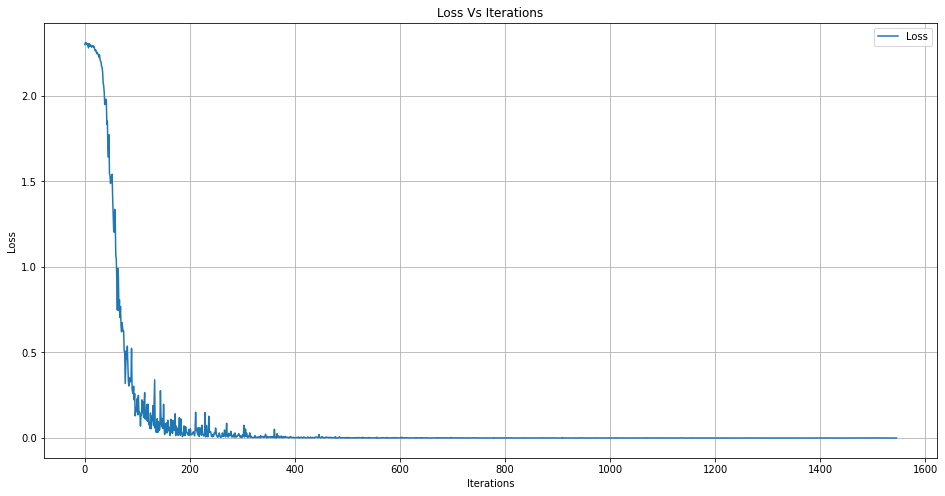

In [25]:
model.plot_losses(model.train_losses)

In [26]:
model.accuracy()


Test acc: 1.0000


In [27]:
torch.save(model.state_dict(), 'nepali_digit_classifier.pth')